In [1]:
pip install pygam

Note: you may need to restart the kernel to use updated packages.


In [2]:
# -*- coding: utf-8 -*-
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from pygam import LogisticGAM
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [3]:
import spacy
from nltk import tokenize 
from nltk.tokenize import TweetTokenizer
from collections import Counter
nlp = spacy.load('en_core_web_sm')

from nltk.stem import WordNetLemmatizer
import nltk
nltk.download("wordnet")

In [4]:
def remove_stopwords(df):
    #tweets = data['cleansed_text']
    fragments = df
    nlp = spacy.load('en_core_web_sm')

    # Can manually add words which you think might not be helpful
    wordsToRemove = set()
    #wordsToRemove.add('help')
    
    # Create array of clean tweets, lower case, no stop words or small words, no hyperlinks
    cleanedFragments = []
    tknzr = TweetTokenizer()
    for t in fragments: 
        cleaned = [word for word in tknzr.tokenize(t.lower()) 
                   if word not in nlp.Defaults.stop_words 
                   if word not in wordsToRemove
                   and len(word) > 2
                   and 'http://' not in word
                   and 'https://' not in word
                  ] 
        cleanedFragments.append(' '.join(cleaned))

    return cleanedFragments

In [26]:
def lemmatization(cleanedFragment):
    
    tknzr = TweetTokenizer()
    wnl = WordNetLemmatizer()

    lemmaFragment = []
    for t in cleanedFragment: 
        cleaned = [wnl.lemmatize(word) for word in tknzr.tokenize(t)] 
        lemmaFragment.append(' '.join(cleaned))

    lemmaTokens = []
    for l in lemmaFragment:
        lemmaTokens.append(tknzr.tokenize(l))
        
    return lemmaTokens

In [27]:
def plot_words(top_freq):
    
    keys = []
    values = []

    for k, v in top_freq:
        keys.append(k)
        values.append(v)

    plt.figure(figsize=(16, 8))
    plt.bar(keys, values)
    plt.title('Most common word Frequency')

In [28]:
def pos_tagging(df):
    
    # Build lists of all adjectives, nouns, and verbs. Count frequency by part of speech
    
    adjs = []
    nouns = []
    verbs = []
    puncts = []

    for t in df['cleansed_text']:
        for token in nlp(t):
            if token.pos_ == 'ADJ':
                adjs.append(token.text)
            elif token.pos_ == 'NOUN':
                nouns.append(token.text)
            elif token.pos_ == 'VERB':
                verbs.append(token.text)
            elif token.is_punct == True:
                puncts.append(token.text)

    adj_counter = Counter(adjs)
    noun_counter = Counter(nouns)
    verb_counter = Counter(verbs) 
    punct_counter = Counter(puncts)

    # Store top 10 highest frequency words for each.
    adj_common = adj_counter.most_common(10)
    noun_common = noun_counter.most_common(10)
    verb_common = verb_counter.most_common(10)
    punct_common = punct_counter.most_common(10)

    plot_words(adj_common)
    plot_words(noun_common)
    plot_words(verb_common)
    plot_words(punct_common)

In [7]:
class Data_Processor:
    def __init__(self, df, words_indexes=list(), chars_indexes=list(), is_unuseful=None):
        self.df = df
        self.words_indexes = words_indexes
        self.chars_indexes = chars_indexes
        self.all_fragments = [row for row in df['cleansed_text']]
        #self.all_fragments = remove_stopwords(df['cleansed_text'])
        self.char_counts_all = dict()
        self.word_counts_all = dict()
        if is_unuseful is not None:
            self.unuseful_fragments = [row for row in df[is_unuseful == True]['cleansed_text']]
            self.char_counts_unuseful = dict()
            self.word_counts_unuseful = dict()

    # count each punctuation in the fragments
    @staticmethod
    def count_chars(fragment, char_counts):
        for char in fragment:
            if char in string.punctuation:
                if char in char_counts:
                    char_counts[char] += 1
                else:
                    char_counts[char] = 1
        return char_counts

    # count each word in the fragments
    @staticmethod
    def count_words(fragment, word_counts):
        words = re.split(r'[!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~\s\n]+', fragment.lower())  # r'[.,?!:;&-\'|<>/\s\n]+'
        for word in words:
            if word:
                if word in word_counts:
                    word_counts[word] += 1
                else:
                    word_counts[word] = 1
        return word_counts

    def summary(self):
        # count chars and words for  whole fragments
        for fragment in self.all_fragments:
            self.char_counts_all = self.count_chars(fragment, self.char_counts_all)
            self.word_counts_all = self.count_words(fragment, self.word_counts_all)

        # count chars and words for unuseful fragments if exists
        if self.unuseful_fragments is not None:
            for fragment in self.unuseful_fragments:
                self.char_counts_unuseful = self.count_chars(fragment, self.char_counts_unuseful)
                self.word_counts_unuseful = self.count_words(fragment, self.word_counts_unuseful)

    # show the figures of frequency
    def plot(self, char_counts, word_counts, char_min_freq=0, word_min_freq=0):
        sorted_chars = {k: v for k, v in sorted(char_counts.items(), key=lambda item: item[1]) if
                        v > char_min_freq}
        print(sorted_chars)
        plt.figure(1)
        plt.barh(list(sorted_chars.keys()), list(sorted_chars.values()))
        plt.show()

        sorted_words = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1]) if
                        v > word_min_freq}
        print(sorted_words)
        plt.figure(2)
        plt.barh(list(sorted_words.keys()), list(sorted_words.values()))
        plt.show()

    def select_words(self, word_num):
        # sort dicts
        sorted_words_all = {k: v for k, v in sorted(self.word_counts_all.items(), key=lambda item: item[1])}
        sorted_words_unuseful = {k: v for k, v in sorted(self.word_counts_unuseful.items(), key=lambda item: item[1])}

        # get the keys for dict_all
        word_keys_all = list(sorted_words_all.keys())
        word_keys_all.reverse()

        # get the keys for dict_unuseful
        word_keys_unuseful = list(sorted_words_unuseful.keys())
        word_keys_unuseful.reverse()

        # select words indexes for model
        for i in range(word_num):
            if word_keys_unuseful[i] != word_keys_all[i]:
                self.words_indexes.append(word_keys_unuseful[i])


    # transform original dataframe to frequency dataframe
    def data_processing(self):
        # define a dict to store columns for new dataframe
        newdf_dict = dict()
        # define word_freq and add them into the newdf_dict
        for word in self.words_indexes:
            newdf_dict["word_freq_{}".format(word)] = list()

        # define word_freq and add them into the newdf_dict
        for char in self.chars_indexes:
            newdf_dict["char_freq_{}".format(char)] = list()

        # define other variables
        newdf_dict["capital_run_length_average"] = list()
        newdf_dict["capital_run_length_longest"] = list()
        newdf_dict["capital_run_length_total"] = list()
        newdf_dict["fragment_length"] = list()

        for fragment in self.all_fragments:
            char_counts_each = dict()
            word_counts_each = dict()
            char_counts_each = self.count_chars(fragment, char_counts_each)
            word_counts_each = self.count_words(fragment, word_counts_each)

            # word_freq_WORD
            # = percentage of words in the e-mail that match WORD,
            # i.e. 100 * (number of times the WORD appears in the e-mail) / total number of words in e-mail.
            for word in self.words_indexes:
                newdf_dict["word_freq_{}".format(word)].append((100 * word_counts_each[word] / sum(
                    word_counts_each.values()) if word in word_counts_each.keys() else 0))

            # char_freq_CHAR
            # = percentage of characters in the e-mail that match CHAR,
            # i.e. 100 * (number of the CHAR appears in the e-mail) / total characters in e-mail
            for char in self.chars_indexes:
                newdf_dict["char_freq_{}".format(char)].append(100 * char_counts_each[char] / sum(
                    char_counts_each.values()) if char in char_counts_each.keys() else 0)

            # capital_run_length_average
            # = average length of uninterrupted sequences of capital letters
            capital_runs = re.findall(r"[A-Z]+", fragment)
            capital_runs_length = [len(string) for string in capital_runs]
            newdf_dict["capital_run_length_average"].append(sum(capital_runs_length) / len(capital_runs_length) \
                                                                if len(capital_runs_length) != 0 else 0)

            # capital_run_length_longest
            # = length of the longest uninterrupted sequence of capital letters
            newdf_dict["capital_run_length_longest"].append(
                len(max(capital_runs, key=len)) if len(capital_runs_length) != 0 else 0)

            # capital_run_length_total
            # = sum of length of uninterrupted sequences of capital letters
            # i.e. = total number of capital letters
            newdf_dict["capital_run_length_total"].append(sum(capital_runs_length))

            # fragment_length
            # = length of a fragment
            newdf_dict["fragment_length"].append(len(fragment))

        # define new dataframe
        newdf = pd.DataFrame.from_dict(newdf_dict)
        return newdf

    @staticmethod
    def log_transform(newdf):
        newdf_log = np.log(0.1 + newdf)
        return newdf_log


In [8]:
class Logistic_Regression:
    def __int__(self):
        print("Building a GAM model")

    @staticmethod
    def split_train_test(df, is_unuseful):
        # split the data into training and test
        X_train, X_test, y_train, y_test = train_test_split(df, is_unuseful * 1, test_size=0.33,
                                                            random_state=1)
        return X_train, X_test, y_train, y_test

    @staticmethod
    def training(X_train, y_train):
        # fit a GAM model
        gam = LogisticGAM().fit(X_train, y_train)

        # get the training accuracy
        gam.accuracy(X_train, y_train)
        print("Training Accuracy: {} ".format(gam.accuracy(X_train, y_train)))

        return gam

    @staticmethod
    def summary(gam):
        # get the model summary
        gam.summary()

    @staticmethod
    def predict(gam, X_test, y_test):
        predictions = gam.predict(X_test)
        print("Accuracy: {} ".format(accuracy_score(y_test, predictions)))
        probas = gam.predict_proba(X_test)
        print("Log Loss: {} ".format(log_loss(y_test, probas)))


In [9]:
class SVC_Model:
    def __int__(self):
        print("Building a SVC model")

    @staticmethod
    def split_train_test(df, is_unuseful):
        # split the data into training and test
        X_train, X_test, y_train, y_test = train_test_split(df, is_unuseful * 1, test_size=0.20,
                                                            random_state=1)
        return X_train, X_test, y_train, y_test

    @staticmethod
    def training(X_train, y_train):
        
        # fit a SVC model
        clf = SVC(kernel='linear', probability=True) 
        svc_m = clf.fit(X_train, y_train)

        # get the training accuracy
        #svc_m.accuracy(X_train, y_train)
        #print("Training Accuracy: {} ".format(svc_m.accuracy(X_train, y_train)))

        return svc_m

    @staticmethod
    def summary(svc):
        # get the model summary
        svc.summary()

    @staticmethod
    def predict(svc_m, X_test, y_test):
        predictions = svc_m.predict(X_test)
        print("Accuracy: {} ".format(accuracy_score(y_test, predictions)))
        probas = svc_m.predict_proba(X_test)
        print("Log Loss: {} ".format(log_loss(y_test, probas)))
        
        return predictions

False    706
True     203
Name: is_unuseful, dtype: int64
       Unnamed: 4
count         0.0
mean          NaN
std           NaN
min           NaN
25%           NaN
50%           NaN
75%           NaN
max           NaN
0       True
1       True
2       True
3      False
4       True
       ...  
975     True
976    False
977    False
978    False
979    False
Name: is_unuseful, Length: 909, dtype: bool
{',': 13, '=': 14, '_': 29, '+': 30, '(': 42, ')': 46, ':': 141, '#': 149, '/': 216, '@': 233, '<': 262, '>': 267, "'": 335, '.': 1441, '-': 1703}


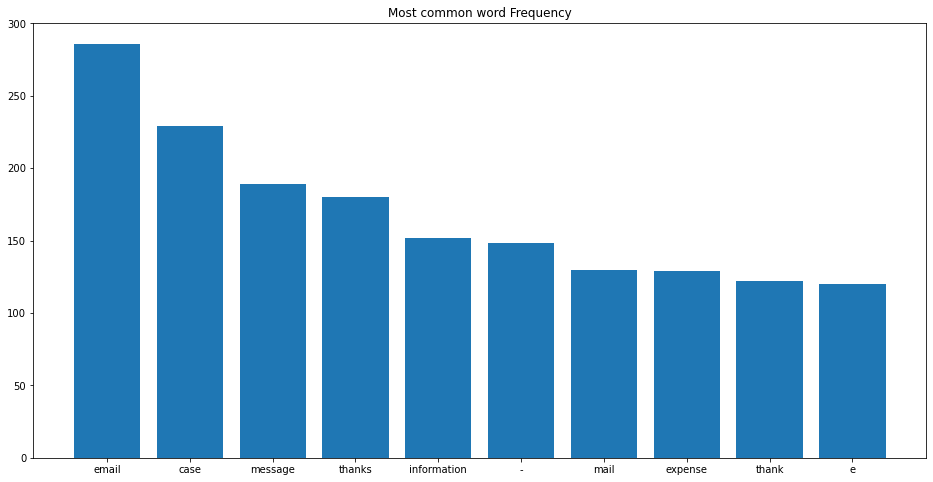

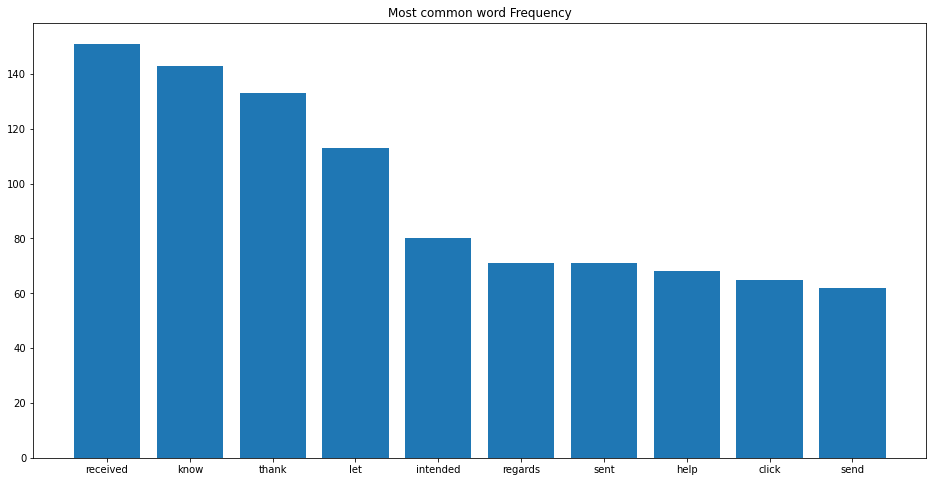

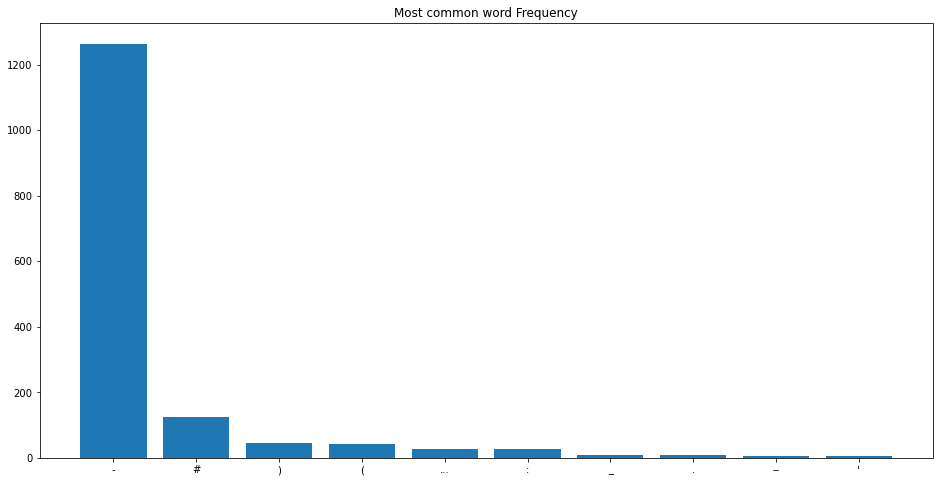

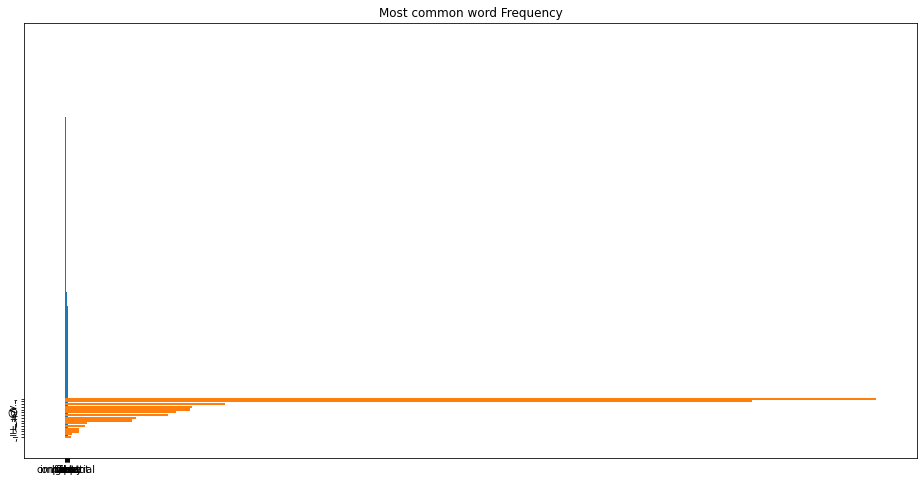

{'case': 231, 'concur': 231, 'thank': 272, 'email': 294, 'com': 332}


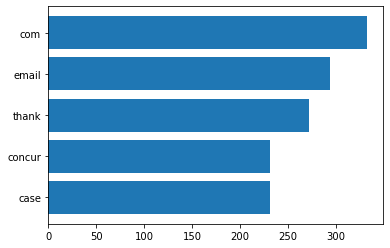

{',': 1, '+': 3, '_': 4, '=': 8, '(': 9, ')': 10, '#': 37, '/': 45, '<': 63, '>': 64, ':': 68, '@': 84, "'": 87, '-': 495, '.': 848}


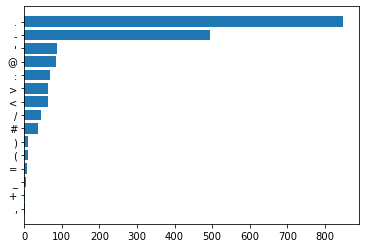

{'email': 115, 'case': 116, 'com': 188}


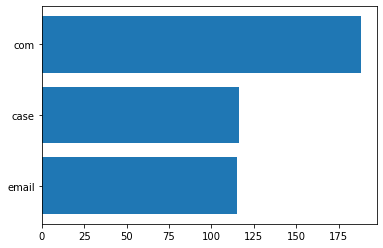

Words Indexes: ['case', 'email', 'received', '2', 'message', 'thank', 'services', 'support', 'mail', 'concur', 'e', 'new', 'request', 'field', '10', '2013', 'information', 'contact', 'jul', 'help', 'server', '0000', 'office', 'team', 'know', 'x', '1', 's', 'respond', 'updates', 'link', 'soon', 'hours', 'salesforce', 'send', 'thanks', 'mta', 'fri', 'chatbooks', 'account', 'questions', 'rural', 'recipient', 'travel', 'assigned', 'use', 'pages', 'create', 'address', 'sfdc', '3', 'time', 'was', 'microsoft'] 
Chars Indexes: [':', '-', '*', ';', "'", '!', '@', '#', '$'] 
Training Accuracy: 0.8538587848932676 
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     31.0989
Link Function:                        LogitLink Log Likelihood:     

<ipython-input-8-fadb03e97087>:26: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


In [10]:
# import the dataset
df = pd.read_excel("Labeled Data.xlsx")
df = df.drop_duplicates(subset="cleansed_text")  # drop duplicates

# summary of initial dataset
print(df['is_unuseful'].value_counts())
print(df.describe())

# define the label column
is_unuseful = df['is_unuseful']
print(is_unuseful)

# define the words/chars indexes
chars_indexes = [':', '-', '*', ';', '\'', '!', '@', '#', '$']

# Remove stopwords and replace with cleansed text.
df['cleansed_text'] = remove_stopwords(df['cleansed_text'])

# Exploratory Data Analysis of words
pos_tagging(df)

dp = Data_Processor(df, words_indexes=list(), chars_indexes=chars_indexes, is_unuseful=is_unuseful)

# get the words/chars count for all fragments and unuseful fragments
dp.summary()
# print(dp.word_counts_all)
# print(dp.char_counts_all)
# print(dp.word_counts_unuseful)
# print(dp.char_counts_unuseful)

# show the boxplots of frequency for all fragments and unuseful fragments
dp.plot(dp.char_counts_all, dp.word_counts_all, char_min_freq=0, word_min_freq=200)
dp.plot(dp.char_counts_unuseful, dp.word_counts_unuseful, char_min_freq=0, word_min_freq=100)

# choose words indexes
dp.select_words(word_num=55)
print("Words Indexes: {} ".format(dp.words_indexes))
print("Chars Indexes: {} ".format(chars_indexes))

# data processing and get the new dataframe
newdf = dp.data_processing()
newdf_log = dp.log_transform(newdf)

# MODEL PART
lg_model = Logistic_Regression()
# split training and test data set
X_train, X_test, y_train, y_test = lg_model.split_train_test(newdf_log, is_unuseful*1)

# training the model
gam = lg_model.training(X_train, y_train)

# summary of the model
lg_model.summary(gam)

# prediction
lg_model.predict(gam, X_test, y_test)

In [11]:
print("Implementing SVM Model")

# MODEL PART
sv = SVC_Model()

# split training and test data set
X_train, X_test, y_train, y_test = sv.split_train_test(newdf_log, is_unuseful*1)

# training the model
svmm = sv.training(X_train, y_train)

#sv.summary(svmm)

predicted_label = sv.predict(svmm, X_test, y_test)

Implementing SVM Model
Accuracy: 0.8516483516483516 
Log Loss: 0.3720066766685057 


In [12]:
Test_label = y_test

Accuracy_Score = accuracy_score(Test_label, predicted_label)
Precision_Score = precision_score(Test_label, predicted_label,  average="macro")
Recall_Score = recall_score(Test_label, predicted_label,  average="macro")
F1_Score = f1_score(Test_label, predicted_label,  average="macro")

print('Average Accuracy: %0.2f' % (Accuracy_Score.mean()*100))
print('Average Precision: %0.2f' % (Precision_Score.mean()*100))
print('Average Recall: %0.2f' % (Recall_Score.mean()*100))
print('Average F1-Score: %0.2f' % (F1_Score.mean()*100))

CM = confusion_matrix(Test_label, predicted_label)
print(CM)
print("\nClassification Report\n")
print(classification_report(y_test, predicted_label))

Average Accuracy: 85.16
Average Precision: 85.93
Average Recall: 71.64
Average F1-Score: 75.31
[[135   3]
 [ 24  20]]

Classification Report

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       138
           1       0.87      0.45      0.60        44

    accuracy                           0.85       182
   macro avg       0.86      0.72      0.75       182
weighted avg       0.85      0.85      0.83       182



In [13]:
df['cleansed_text'] = remove_stopwords(df['cleansed_text'])
df

,cleansed_text,created_at,class,is_unuseful,Unnamed: 4
0,help alyssa understand,2022-08-26 15:37:28.000000 UTC,chat,True,NaN
1,update closing conversation didn hear feel fre...,2022-08-26 15:37:15.000000 UTC,chat,True,NaN
2,case 04972861 request received field services ...,2014-06-06 13:28:15.000000 UTC,chat,True,NaN
3,wayne unfortunately field populated report hea...,2015-11-10 18:32:39.000000 UTC,chat,False,NaN
4,case 15443630 request received field services ...,2020-03-11 18:12:22.000000 UTC,chat,True,NaN
...,...,...,...,...,...
975,help jeremy understand,2020-04-26 14:06:35.000000 UTC,chat,True,NaN
976,alan thank clarifying able send exp utility bi...,2020-04-26 13:55:47.000000 UTC,chat,False,NaN
977,alan appreciate diligent response reviewed doc...,2020-04-26 15:38:45.000000 UTC,chat,False,NaN
978,alan thank interest zayzoon reviewing noticed ...,2020-04-26 02:09:06.000000 UTC,chat,False,NaN


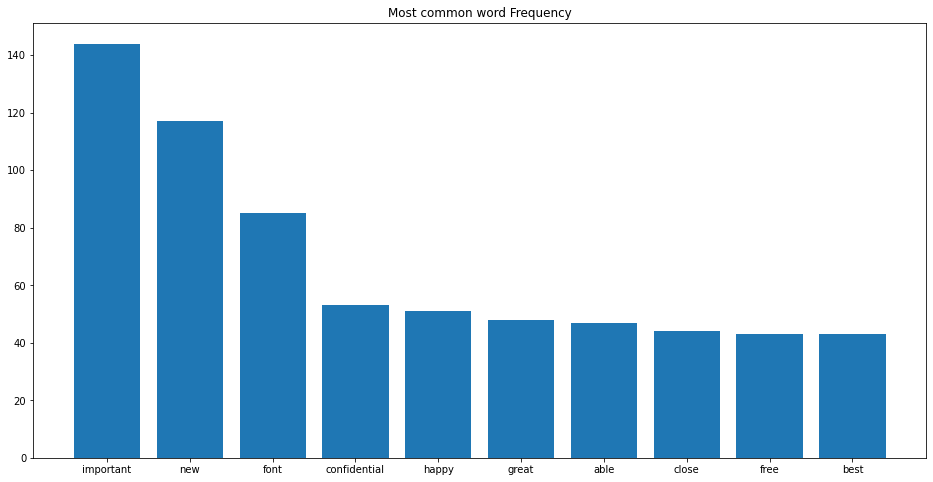

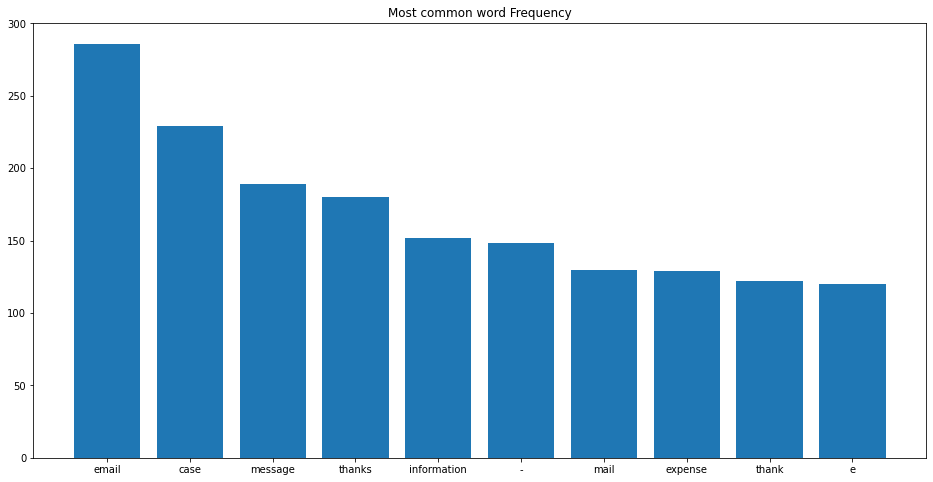

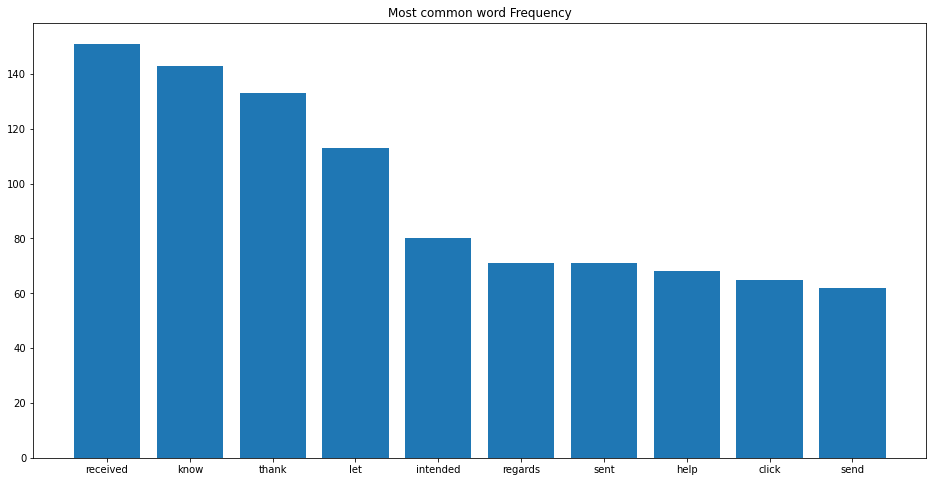

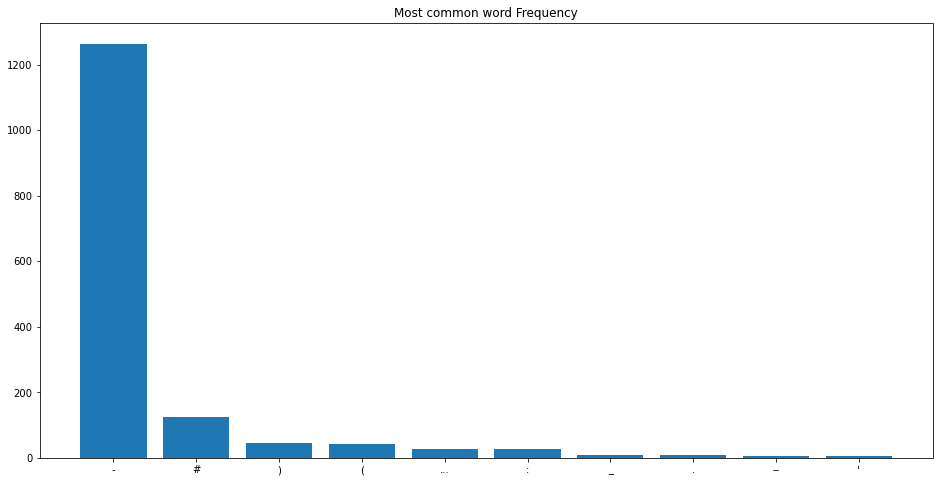

In [14]:
pos_tagging(df)

In [29]:
lemmatization(remove_stopwords(df['cleansed_text']))

[['help', 'alyssa', 'understand'], ['update', 'closing', 'conversation', 'didn', 'hear', 'feel', 'free', 'respond', 'anytime', 'happy', 'assist'], ['case', '04972861', 'request', 'received', 'field', 'service', 'contacted', 'soon', 'assigned', 'case', 'owner', 'reply', 'email', 'reference', 'case', '04972861', 'question', 'status', 'request', 'send', 'new', 'email', 'committed', 'success', 'thank', 'field', 'service', 'team', 'fieldservices@concur.com'], ['wayne', 'unfortunately', 'field', 'populated', 'report', 'header', 'form', 'create', 'custom', 'field', 'custom', 'employee', 'form', 'need', 'populated', 'itg', 'system', 'use', 'field', 'copy', 'report', 'header', 'custom', 'field', 'populate', 'accounting', 'extract', 'thanks', 'lynn', 'time', 'zone', 'gmt', 'toll', 'free', '877-808-9650', '257352', 'join', 'march', '2016', 'la', 'vega', 'fusion', '2016', 'advance', 'notice', 'office', 'friday', 'november', 'returning', 'monday', 'november', '23rd'], ['case', '15443630', 'request'

[['help', 'alyssa', 'understand'],
 ['update',
  'closing',
  'conversation',
  'didn',
  'hear',
  'feel',
  'free',
  'respond',
  'anytime',
  'happy',
  'assist'],
 ['case',
  '04972861',
  'request',
  'received',
  'field',
  'service',
  'contacted',
  'soon',
  'assigned',
  'case',
  'owner',
  'reply',
  'email',
  'reference',
  'case',
  '04972861',
  'question',
  'status',
  'request',
  'send',
  'new',
  'email',
  'committed',
  'success',
  'thank',
  'field',
  'service',
  'team',
  'fieldservices@concur.com'],
 ['wayne',
  'unfortunately',
  'field',
  'populated',
  'report',
  'header',
  'form',
  'create',
  'custom',
  'field',
  'custom',
  'employee',
  'form',
  'need',
  'populated',
  'itg',
  'system',
  'use',
  'field',
  'copy',
  'report',
  'header',
  'custom',
  'field',
  'populate',
  'accounting',
  'extract',
  'thanks',
  'lynn',
  'time',
  'zone',
  'gmt',
  'toll',
  'free',
  '877-808-9650',
  '257352',
  'join',
  'march',
  '2016',
  'l

In [31]:
X_train

,word_freq_case,word_freq_email,word_freq_received,word_freq_2,word_freq_message,word_freq_thank,word_freq_services,word_freq_support,word_freq_mail,word_freq_concur,...,char_freq_;,char_freq_',char_freq_!,char_freq_@,char_freq_#,char_freq_$,capital_run_length_average,capital_run_length_longest,capital_run_length_total,fragment_length
238,1.450833,1.450833,-2.302585,-2.302585,-2.302585,2.132192,-2.302585,-2.302585,-2.302585,1.450833,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,5.165357
411,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3.222868
16,-2.302585,1.788814,-2.302585,-2.302585,-2.302585,1.788814,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,4.544358
554,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.741937,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,5.932510
756,-2.302585,2.053137,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,5.165357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,3.468856
767,-2.302585,2.264240,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,4.991113
72,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,3.914021,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,5.323498
235,-2.302585,1.980016,-2.302585,-2.302585,-2.302585,1.980016,-2.302585,-2.302585,-2.302585,-2.302585,...,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,4.489759
